In [1]:
!pip install split-folders
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

import zipfile,os
import splitfolders
import numpy as np
from google.colab import files
from keras.preprocessing import image
import keras
import shutil

In [36]:
import pathlib

## Download Rice leaf Disease Dataset from Kaggle

In [2]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

Done


In [3]:
! kaggle datasets download badhon7432/paddyleafdiseaseuci

 97% 156M/161M [00:01<00:00, 116MB/s]
100% 161M/161M [00:01<00:00, 109MB/s]


In [4]:
! kaggle datasets download vbookshelf/rice-leaf-diseases

 74% 27.0M/36.7M [00:00<00:00, 63.3MB/s]
100% 36.7M/36.7M [00:00<00:00, 82.5MB/s]


In [5]:
local_zip = '/content/paddyleafdiseaseuci.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
local_zip = '/content/rice-leaf-diseases.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
os.listdir("/content/train")

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [8]:
#Blok menggabungkan 2 dataset
#Coba bandingkan tidak jalankan blok ini, dan dengan menjalankan blok ini
root_dir = '/content/rice_leaf_diseases' # data root path
classes_dir = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut'] #total labels

val_ratio = 0.2
test_ratio = 0.2

total_data = 0
total_train_data = 0 
total_validation_data = 0
total_test_data = 0
for cls in classes_dir:
  # Creating partitions of the data after shuffeling
    src = root_dir + '/' + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    print(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                              int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, '/content/train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, '/content/valid/' + cls)

    for name in test_FileNames:
        shutil.copy(name, '/content/test/' + cls)

    #count total images
    total_data += len(allFileNames)
    total_train_data += len(train_FileNames)
    total_validation_data += len(val_FileNames)
    total_test_data += len(test_FileNames)


print('Total images: ', total_data)
print('Training: ', total_train_data)
print('Validation: ', total_validation_data)
print('Testing: ', total_test_data)

/content/rice_leaf_diseases/Bacterial leaf blight
/content/rice_leaf_diseases/Brown spot
/content/rice_leaf_diseases/Leaf smut
Total images:  120
Training:  72
Validation:  24
Testing:  24


In [9]:
!rm -rf rice_leaf_diseases_train
!rm -rf rice_leaf_diseases_val
!rm -rf rice_leaf_diseases_test

## Augmentasi Gambar

In [10]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    #validation_split = 0.4,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    rescale=1./255)

test_datagen = ImageDataGenerator(
                    rescale=1./255)



In [11]:
train_dir = "/content/train"
validation_dir = "/content/valid"
testing_dir = "/content/test"

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(160, 160),  
        batch_size=32,
        class_mode='categorical') 
        
 
validation_generator = val_datagen.flow_from_directory(
        validation_dir, 
        target_size=(160, 160), 
        batch_size=32, 
        class_mode='categorical')
        
 
testing_generator = test_datagen.flow_from_directory(
        testing_dir, 
        target_size=(160, 160), 
        batch_size=32, 
        class_mode='categorical')

Found 929 images belonging to 3 classes.
Found 237 images belonging to 3 classes.
Found 183 images belonging to 3 classes.


# MobileNetV2

In [48]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [49]:
train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet_v2.preprocess_input) #To ensure that your images are pre-processed as expected for the pre-trained network you are using.

In [50]:
base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(160,160,3))
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [51]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [54]:
x = base_model.output
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)         
prediction=layers.Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction) 

## Compile Model

In [55]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [56]:
class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97):
      print("Akurasi Diatas 97%")
      self.model.stop_training = True

In [57]:
history = model.fit(
      train_generator,
      steps_per_epoch=30,  
      epochs=20,
      validation_data=validation_generator, 
      validation_steps=4,
      callbacks=[CustomCallback()],  
     )

Epoch 1/20
30/30 [==============================] - 11s 271ms/step - loss: 1.4172 - accuracy: 0.3809 - val_loss: 0.6900 - val_accuracy: 0.6250
Epoch 2/20
30/30 [==============================] - 7s 224ms/step - loss: 0.8846 - accuracy: 0.6086 - val_loss: 0.4866 - val_accuracy: 0.9375
Epoch 3/20
30/30 [==============================] - 7s 224ms/step - loss: 0.6641 - accuracy: 0.7446 - val_loss: 0.4461 - val_accuracy: 0.7500
Epoch 4/20
30/30 [==============================] - 7s 231ms/step - loss: 0.5173 - accuracy: 0.7962 - val_loss: 0.5383 - val_accuracy: 0.8125
Epoch 5/20
30/30 [==============================] - 7s 227ms/step - loss: 0.3161 - accuracy: 0.9092 - val_loss: 0.2724 - val_accuracy: 0.8125
Epoch 6/20
30/30 [==============================] - 7s 249ms/step - loss: 0.4098 - accuracy: 0.7904 - val_loss: 0.3855 - val_accuracy: 0.8125
Epoch 7/20
30/30 [==============================] - 7s 231ms/step - loss: 0.4269 - accuracy: 0.8345 - val_loss: 0.6234 - val_accuracy: 0.6875
Epoch

## Ploting Model

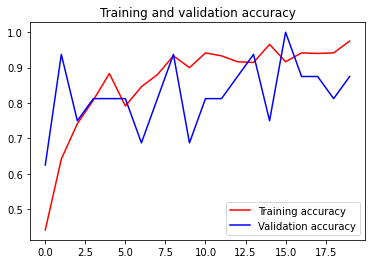

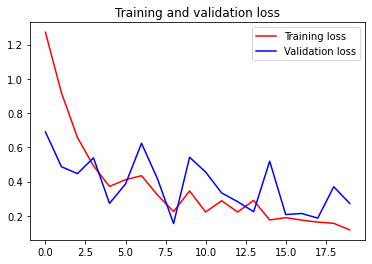

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

## Test Upload

In [59]:
#fungsi untuk mendapatkan label indeks hasil deteksi
def get_class_string_from_index(index):
   for class_string, class_index in validation_generator.class_indices.items():
      if class_index == index:
         return class_string

Saving IMG_3091.jpg to IMG_3091.jpg
{'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}
Brown spot
Hasil Prediksi: Brown spot


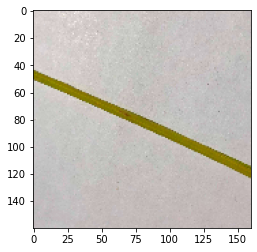

In [64]:
uploaded = files.upload()
print(train_generator.class_indices) 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(160,160))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  print(get_class_string_from_index(predicted_index))
  print("Hasil Prediksi: " + get_class_string_from_index(predicted_index))

##Export the Model

In [65]:
UseMobileNet_Saved_Model="exp_saved_model"

In [66]:
tf.saved_model.save(model,UseMobileNet_Saved_Model)

INFO:tensorflow:Assets written to: exp_saved_model/assets


In [67]:
optimization = tf.lite.Optimize.DEFAULT
converter = tf.lite.TFLiteConverter.from_saved_model(UseMobileNet_Saved_Model)
converter.optimizations = [optimization]
tflite_model = converter.convert()

In [68]:
tflite_model_file = pathlib.Path('./model1.tflite')
tflite_model_file.write_bytes(tflite_model)

2630896

## Hasil sementara
model memiliki akurasi yang tidak begitu tinggi dan hasil upload hanya  memberikan label Bacterial leaf Blight 

# Inception Layer

In [20]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (160, 160, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-05-19 08:30:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 142.250.97.128, 74.125.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   151MB/s    in 0.6s    

2021-05-19 08:30:43 (151 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 8, 8, 768)


In [21]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers


x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense  (3, activation='softmax')(x)           

model2 = Model( pre_trained_model.input, x) 

# model.compile(optimizer = RMSprop(lr=0.0001), 
#               loss = 'binary_crossentropy', 
#               metrics = ['accuracy'])

## Compile Model

In [22]:
model2.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [23]:
history = model2.fit(
      train_generator,
      steps_per_epoch=30,  
      epochs=25,
      validation_data=validation_generator, 
      validation_steps=4, 
     )

Epoch 1/25
30/30 [==============================] - 17s 466ms/step - loss: 6.8236 - accuracy: 0.4376 - val_loss: 6.2798 - val_accuracy: 0.5625
Epoch 2/25
30/30 [==============================] - 13s 428ms/step - loss: 3.7615 - accuracy: 0.5890 - val_loss: 0.6055 - val_accuracy: 0.7500
Epoch 3/25
30/30 [==============================] - 13s 431ms/step - loss: 1.9851 - accuracy: 0.6905 - val_loss: 0.5990 - val_accuracy: 0.8125
Epoch 4/25
30/30 [==============================] - 13s 428ms/step - loss: 0.6994 - accuracy: 0.7855 - val_loss: 0.4268 - val_accuracy: 0.8750
Epoch 5/25
30/30 [==============================] - 13s 439ms/step - loss: 0.5491 - accuracy: 0.7791 - val_loss: 0.5237 - val_accuracy: 0.7500
Epoch 6/25
30/30 [==============================] - 13s 439ms/step - loss: 0.5010 - accuracy: 0.8671 - val_loss: 0.5994 - val_accuracy: 0.8750
Epoch 7/25
30/30 [==============================] - 13s 439ms/step - loss: 0.4520 - accuracy: 0.8398 - val_loss: 0.1173 - val_accuracy: 1.0000

## Ploting Model

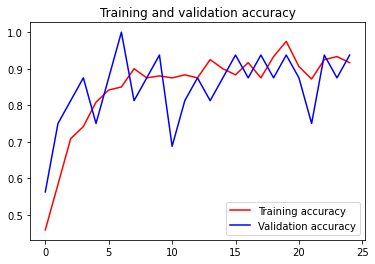

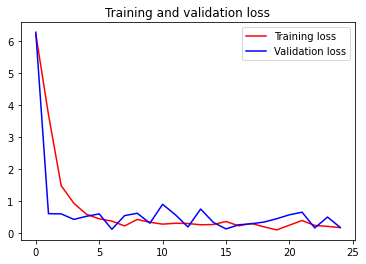

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [25]:
predict=model2.predict(testing_generator)
score = model2.evaluate(testing_generator, batch_size=1, verbose=1)

46/46 [==============================] - 14s 291ms/step - loss: 0.1621 - accuracy: 0.9617


## Test Upload

Saving unnamed.jpg to unnamed (1).jpg
{'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}
Bacterial leaf blight
Hasil Prediksi: Bacterial leaf blight


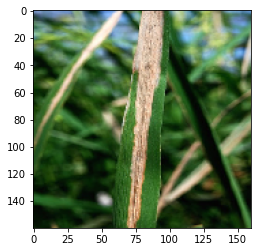

In [31]:
uploaded = files.upload()
print(train_generator.class_indices) 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(160,160))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  print(get_class_string_from_index(predicted_index))
  print("Hasil Prediksi: " + get_class_string_from_index(predicted_index))

## Hasil sementara
model memiliki akurasi yang tidak cukup tinggi dan hasil upload cenderung memberi prediksi leaf smut 
(**Note(2):Bisa membedakan leaf smut dan BLB tapi belum brown spot)

##Export Inception

In [32]:
UseInception_Saved_Model="exp_saved_model"

In [33]:
tf.saved_model.save(model2,UseInception_Saved_Model)

INFO:tensorflow:Assets written to: exp_saved_model/assets


In [34]:
optimization = tf.lite.Optimize.DEFAULT
converter = tf.lite.TFLiteConverter.from_saved_model(UseInception_Saved_Model)
converter.optimizations = [optimization]

In [37]:
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('./model2.tflite')
tflite_model_file.write_bytes(tflite_model)

34376016